In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np, pandas as pd, seaborn as sns, tensorflow as tf, tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading Input Data

In [3]:
inputdata=pd.read_excel('/content/input_data.xlsx')
inputdata

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8495,emails not coming in from zz mail,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


# Exploratory Data Analysis
## Observations:
1.   Short Description is repeated in Description in many records - Redundant, will be dropped
2.   Caller Name is repeated in Description in many places (not required for our analysis) - Caller column will be dropped
3.   There are tickets in Spanish as well as German apart from English. But English language is dominant.

### The redundant and unwanted features will be removed during the pre-processing of the data

In [4]:
# Total number of records
inputdata.shape
# There are 8500 records and 4 features

(8500, 4)

In [5]:
# Checking for null values
inputdata.isnull().sum()
# There are 8 null values in Short Description and 1 null value in Description
# Will be dropping the null value in 
## Description (since Description is our feature of interest) during data pre-processing

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

Short Description, considered redundant. So only null values of Description column will be dropped. 

## Distribution of tickets based on Assignment Group

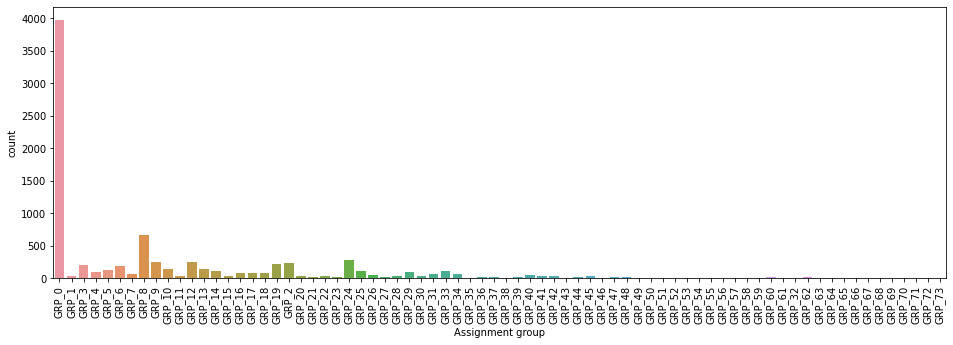

In [7]:
plt.gcf().set_size_inches(16,5)
plt.xticks(rotation=90)
sns.countplot(inputdata['Assignment group'])

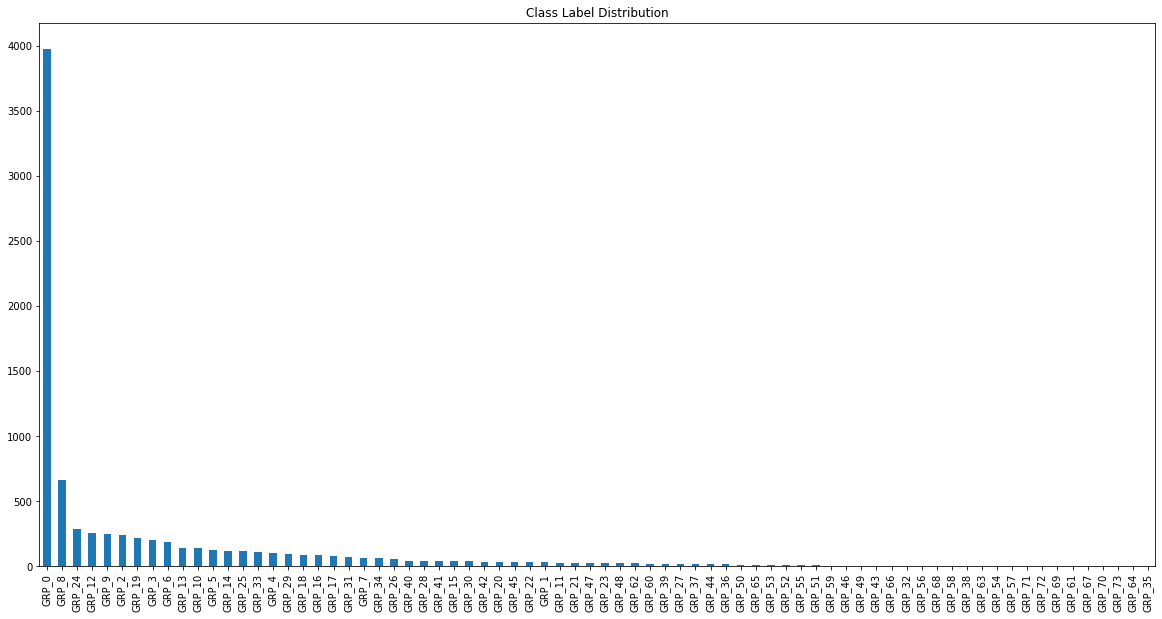

In [8]:
inputdata['Assignment group'].value_counts().plot(kind='bar', figsize=(20,10), title='Class Label Distribution')

In [9]:
# Checking for those assignment groups that have too few tickets (records)
# Defining those assignment groups as low frequency, which have less than 5 tickets assigned to them
freq=pd.DataFrame(inputdata['Assignment group'].value_counts())
freq.reset_index(inplace=True)
freq.rename(columns={0:'Assignment_group',1:'Number of tickets'})
freq[freq['Assignment group']<5]

,index,Assignment group
56,GRP_66,4
57,GRP_32,4
58,GRP_56,3
59,GRP_68,3
60,GRP_58,3
61,GRP_38,3
62,GRP_63,3
63,GRP_54,2
64,GRP_57,2
65,GRP_71,2


In [10]:
freq[freq['Assignment group']<5].count()
#There are 18 low frequency assignment groups. The classification accuracy of these classes might be low.

index               18
Assignment group    18
dtype: int64

## Observations:
1.   The classes are imbalanced. Accuracy score may not be the best performance metric.
2.   Class 0 has the maximum number of tickets assigned, followed by 8, 24, 12, 9, 2 and 19 in that order.



# Data Cleaning and Processing Pipeline

In [11]:
import nltk
from nltk import *
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
#from nltk.corpora import stopwords
print (stopwords.fileids())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Data Processing

In [12]:
for i in range(len(inputdata['Description'])):
    # Removing new line (\n) and carriage return (\r)
    inputdata.iloc[i]['Description']=re.sub('\n',' ',str(inputdata.iloc[i]['Description']))
    inputdata.iloc[i]['Description']=re.sub('\r',' ',str(inputdata.iloc[i]['Description']))
    #inputdata.iloc[i]['Description']=str(inputdata.iloc[i]['Description']).replace(str(inputdata.iloc[i]['Caller']),'')
    # Removing email tails from Description
    inputdata.iloc[i]['Description']=re.sub('@gmail.com',' ',inputdata.iloc[i]['Description'])
    # Removing numbers and special characters from Description
    inputdata.iloc[i]['Description']=re.sub('[^a-zA-Z]',' ',inputdata.iloc[i]['Description'])#0-9
    # Removing 'received from' from the beginning of Description
    inputdata.iloc[i]['Description']=re.sub('received from',' ',inputdata.iloc[i]['Description'])
    #inputdata.iloc[i]['Description']=inputdata.iloc[i]['Description'].lower().lstrip(' ')  
 
inputdata

,Short description,Description,Caller,Assignment group
0,login issue,verified user details employee manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,hmjdrvpb komuaywn hello team my...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,eylqgodm ybqkwiam hi i cannot lo...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8495,emails not coming in from zz mail,avglmrts vhqmtiua good afternoon ...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


In [13]:
for i in range(len(inputdata['Description'])):
    #inputdata.iloc[i]['Description']=re.sub('\n',' ',str(inputdata.iloc[i]['Description']))
    #inputdata.iloc[i]['Description']=re.sub('\r',' ',str(inputdata.iloc[i]['Description']))
    # Removing Caller name from Description
    inputdata.iloc[i]['Description']=inputdata.iloc[i]['Description'].replace(inputdata.iloc[i]['Caller'],'')
inputdata   

,Short description,Description,Caller,Assignment group
0,login issue,verified user details employee manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,hello team my meetings skype m...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,hi i cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8495,emails not coming in from zz mail,good afternoon i am not receivin...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


In [14]:
# Dropping Caller and Short description columns
intermediate=inputdata.drop(['Caller','Short description'],axis=1)
intermediate

,Description,Assignment group
0,verified user details employee manager na...,GRP_0
1,hello team my meetings skype m...,GRP_0
2,hi i cannot log on to vpn best,GRP_0
3,unable to access hr tool page,GRP_0
4,skype error,GRP_0
...,...,...
8495,good afternoon i am not receivin...,GRP_29
8496,telephony software issue,GRP_0
8497,vip windows password reset for tifpdchb pedx...,GRP_0
8498,i am unable to access the machine utilities to...,GRP_62


In [15]:
# Processing Assignment group
# Remove 'GRP_' from Assignment group name and convert the remaining string to integer
for i in range(len(intermediate['Description'])):
    intermediate.iloc[i]['Assignment group']=intermediate.iloc[i]['Assignment group'].replace('GRP_','')
intermediate['Assignment group']=intermediate['Assignment group'].astype(np.int32)
intermediate

,Description,Assignment group
0,verified user details employee manager na...,0
1,hello team my meetings skype m...,0
2,hi i cannot log on to vpn best,0
3,unable to access hr tool page,0
4,skype error,0
...,...,...
8495,good afternoon i am not receivin...,29
8496,telephony software issue,0
8497,vip windows password reset for tifpdchb pedx...,0
8498,i am unable to access the machine utilities to...,62


In [16]:
# Removing double spaces and spaces in the beginning of the Description
# Converting string to tokens
for i in range(len(intermediate['Description'])):
    #if isinstance(intermediate.iloc[i]['Description'],str):
    intermediate['Description'][i]=intermediate['Description'][i].replace('  ',' ').lstrip(' ').split()
intermediate['Description']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0       [verified, user, details, employee, manager, n...
1       [hello, team, my, meetings, skype, meetings, e...
2                 [hi, i, cannot, log, on, to, vpn, best]
3                    [unable, to, access, hr, tool, page]
4                                          [skype, error]
                              ...                        
8495    [good, afternoon, i, am, not, receiving, the, ...
8496                         [telephony, software, issue]
8497    [vip, windows, password, reset, for, tifpdchb,...
8498    [i, am, unable, to, access, the, machine, util...
8499    [an, mehreren, pc, s, lassen, sich, verschiede...
Name: Description, Length: 8500, dtype: object

In [17]:
nltk.download('words')
from nltk.corpus import words
dictionary=words.words()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [18]:
# Removing words that do not make sense using nltk's words
for i in range(len(intermediate['Description'])):
    intermediate['Description'][i]=[x for x in intermediate['Description'][i] if x in dictionary]
    print(intermediate['Description'][i])
intermediate

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
['unable', 'to', 'print', 'from', 'the', 'printer', 'color', 'laser', 'connected', 'to', 'the', 'user', 'system', 'the', 'printer', 'to', 'update', 'tried', 'to', 'install', 'the', 'no', 'go', 'contact', 'computer', 'name', 'user', 'to', 'have', 'local', 'it', 'look', 'as', 'there', 'are', 'many', 'similar', 'issue']
['not', 'works', 'at', 'time']
['the', 'ie', 'to', 'on']
['user', 'to', 'change', 'the', 'printer', 'to']
['account', 'locked']
['name', 'language', 'browser', 'explorer', 'customer', 'number', 'telephone', 'summary', 'i', 'am', 'trying', 'to', 'find', 'an', 'expense', 'report', 'to', 'approve', 'i', 'have', 'an', 'that', 'i', 'have', 'one', 'to', 'approve', 'it', 'is', 'not', 'showing', 'up']
['installation']
['cannot', 'connect', 'to', 'engineering', 'application', 'going', 'through', 'company', 'i', 'can', 'access', 'and', 'through', 'the', 'i', 'can', 'access', 'at', 'the', 'office', 'i', 'can', 'not', 'access', 'remot

,Description,Assignment group
0,"[user, employee, manager, name, checked, the, ...",0
1,"[hello, team, my, are, not, in, my, outlook, c...",0
2,"[hi, i, cannot, log, on, to, best]",0
3,"[unable, to, access, tool, page]",0
4,[error],0
...,...,...
8495,"[good, afternoon, i, am, not, the, that, i, se...",29
8496,"[telephony, issue]",0
8497,"[password, reset, for]",0
8498,"[i, am, unable, to, access, the, machine, to, ...",62


In [19]:
temp=[]
for i in range(len(intermediate['Description'])):
  temp.append(' '.join(intermediate['Description'][i]))
temp

['user employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved',
 'hello team my are not in my outlook calendar can somebody please advise how to correct this kind',
 'hi i cannot log on to best',
 'unable to access tool page',
 'error',
 'unable to log in to engineering tool and',
 'event critical company the value of threshold for oracle d d data d is',
 'ticket no employment status new non employee enter user s name',
 'unable to disable add on outlook',
 'ticket update on',
 'engineering tool not connected and unable to submit',
 'tool site not loading page correctly',
 'unable to login to tool to',
 'user to reset the password',
 'unable to open',
 'ticket update on',
 'company hi i am unable to login to company trying to open a new session the below link but not able to get through help urgently as we are working from home tomorrow due to month end',
 'when screen will n

In [20]:
type(temp)

list

In [21]:
corpus= ' '.join(temp)
corpus

'user employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved hello team my are not in my outlook calendar can somebody please advise how to correct this kind hi i cannot log on to best unable to access tool page error unable to log in to engineering tool and event critical company the value of threshold for oracle d d data d is ticket no employment status new non employee enter user s name unable to disable add on outlook ticket update on engineering tool not connected and unable to submit tool site not loading page correctly unable to login to tool to user to reset the password unable to open ticket update on company hi i am unable to login to company trying to open a new session the below link but not able to get through help urgently as we are working from home tomorrow due to month end when screen will not come back account locked unable to sign into unable to check hello

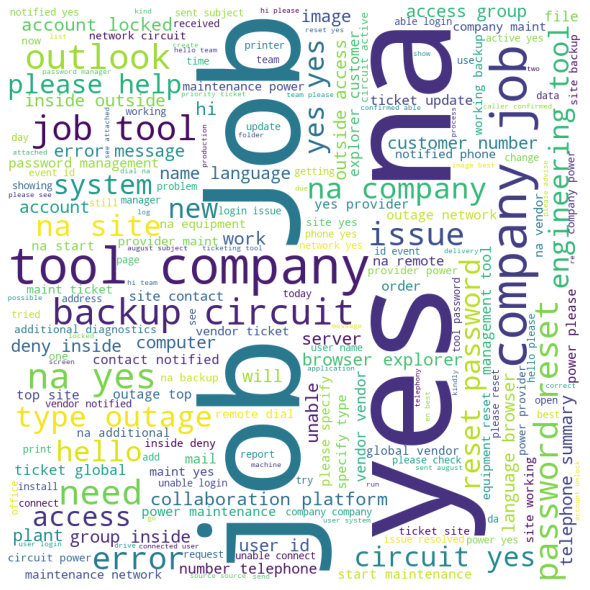

In [23]:
# Using wordcloud to find the most common words in the corpus. Could give an idea of the most common subject
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from random import random
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            #stopwords = stopwords, 
            min_font_size = 10).generate(corpus) #generate(' '.join(inputdata['Description']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

## Observations:
1. Words YES, NA, JOB and COMPANY are most common. But they do not point to any specific issue
2. Next most common are PASSWORD RESET and OUTLOOK: Issues related to Outlook access and resetting password seem to be the most common complaints

In [24]:
# Removing English stopwords from the tokens
for i in range(len(intermediate['Description'])):
    intermediate['Description'][i]= [word for word in intermediate['Description'][i] if not word in stopwords.words('english')]
   # print(intermediate['Description'][i])
intermediate

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Description,Assignment group
0,"[user, employee, manager, name, checked, user,...",0
1,"[hello, team, outlook, calendar, somebody, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unable, access, tool, page]",0
4,[error],0
...,...,...
8495,"[good, afternoon, sent, mail, please, advise]",29
8496,"[telephony, issue]",0
8497,"[password, reset]",0
8498,"[unable, access, machine, finish, drawers, adj...",62


In [25]:
# Removing Spanish and German stopwords
for i in range(len(intermediate['Description'])):
    intermediate['Description'][i]= [word for word in intermediate['Description'][i] if not word in stopwords.words('spanish')]
    intermediate['Description'][i]= [word for word in intermediate['Description'][i] if not word in stopwords.words('german')]
    
    #print(intermediate['Description'][i])
processed=intermediate
processed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Description,Assignment group
0,"[user, employee, manager, name, checked, user,...",0
1,"[hello, team, outlook, calendar, somebody, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unable, access, tool, page]",0
4,[error],0
...,...,...
8495,"[good, afternoon, sent, mail, please, advise]",29
8496,"[telephony, issue]",0
8497,"[password, reset]",0
8498,"[unable, access, machine, finish, drawers, adj...",62


### Checking for Descriptions with less than 2 tokens (any Description with less than 2 words many not make sense)

In [26]:
for i in range(len(processed['Description'])):
  if(len(processed['Description'][i])<2):#==0):
    processed=processed.drop(i,axis=0)
processed

,Description,Assignment group
0,"[user, employee, manager, name, checked, user,...",0
1,"[hello, team, outlook, calendar, somebody, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unable, access, tool, page]",0
5,"[unable, log, engineering, tool]",0
...,...,...
8494,"[tablet, needs, due, multiple]",3
8495,"[good, afternoon, sent, mail, please, advise]",29
8496,"[telephony, issue]",0
8497,"[password, reset]",0


In [27]:
processed.reset_index(inplace=True,drop=True)
processed

,Description,Assignment group
0,"[user, employee, manager, name, checked, user,...",0
1,"[hello, team, outlook, calendar, somebody, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unable, access, tool, page]",0
4,"[unable, log, engineering, tool]",0
...,...,...
7772,"[tablet, needs, due, multiple]",3
7773,"[good, afternoon, sent, mail, please, advise]",29
7774,"[telephony, issue]",0
7775,"[password, reset]",0


Now total number of records is 7777

In [28]:
# Creating Porter Stemmer for stemming the words in Description
p_stemmer = PorterStemmer()
temp=[]
for i in range(len(processed['Description'])):
    #processed.iloc[i]['Description']=[p_stemmer.stem(word) for word in processed.iloc[i]['Description']]
    temp.append([p_stemmer.stem(word) for word in processed.iloc[i]['Description']])
temp

[['user',
  'employe',
  'manag',
  'name',
  'check',
  'user',
  'name',
  'ad',
  'reset',
  'password',
  'advis',
  'user',
  'login',
  'check',
  'caller',
  'confirm',
  'abl',
  'login',
  'issu',
  'resolv'],
 ['hello',
  'team',
  'outlook',
  'calendar',
  'somebodi',
  'pleas',
  'advis',
  'correct',
  'kind'],
 ['hi', 'cannot', 'log', 'best'],
 ['unabl', 'access', 'tool', 'page'],
 ['unabl', 'log', 'engin', 'tool'],
 ['event', 'critic', 'compani', 'valu', 'threshold', 'oracl', 'data'],
 ['ticket',
  'employ',
  'statu',
  'new',
  'non',
  'employe',
  'enter',
  'user',
  'name'],
 ['unabl', 'disabl', 'add', 'outlook'],
 ['ticket', 'updat'],
 ['engin', 'tool', 'connect', 'unabl', 'submit'],
 ['tool', 'site', 'load', 'page', 'correctli'],
 ['unabl', 'login', 'tool'],
 ['user', 'reset', 'password'],
 ['unabl', 'open'],
 ['ticket', 'updat'],
 ['compani',
  'hi',
  'unabl',
  'login',
  'compani',
  'tri',
  'open',
  'new',
  'session',
  'link',
  'abl',
  'get',
  'help'

In [30]:
processed['Description']=temp
processed

,Description,Assignment group
0,"[user, employe, manag, name, check, user, name...",0
1,"[hello, team, outlook, calendar, somebodi, ple...",0
2,"[hi, cannot, log, best]",0
3,"[unabl, access, tool, page]",0
4,"[unabl, log, engin, tool]",0
...,...,...
7772,"[tablet, need, due, multipl]",3
7773,"[good, afternoon, sent, mail, pleas, advis]",29
7774,"[telephoni, issu]",0
7775,"[password, reset]",0


In [31]:
# Observed tokens of length 1 and 2, removing them 
temp=[]
for i in range(len(processed['Description'])):
  temp.append([x for x in processed.iloc[i]['Description'] if len(x)>2])  
temp

[['user',
  'employe',
  'manag',
  'name',
  'check',
  'user',
  'name',
  'reset',
  'password',
  'advis',
  'user',
  'login',
  'check',
  'caller',
  'confirm',
  'abl',
  'login',
  'issu',
  'resolv'],
 ['hello',
  'team',
  'outlook',
  'calendar',
  'somebodi',
  'pleas',
  'advis',
  'correct',
  'kind'],
 ['cannot', 'log', 'best'],
 ['unabl', 'access', 'tool', 'page'],
 ['unabl', 'log', 'engin', 'tool'],
 ['event', 'critic', 'compani', 'valu', 'threshold', 'oracl', 'data'],
 ['ticket',
  'employ',
  'statu',
  'new',
  'non',
  'employe',
  'enter',
  'user',
  'name'],
 ['unabl', 'disabl', 'add', 'outlook'],
 ['ticket', 'updat'],
 ['engin', 'tool', 'connect', 'unabl', 'submit'],
 ['tool', 'site', 'load', 'page', 'correctli'],
 ['unabl', 'login', 'tool'],
 ['user', 'reset', 'password'],
 ['unabl', 'open'],
 ['ticket', 'updat'],
 ['compani',
  'unabl',
  'login',
  'compani',
  'tri',
  'open',
  'new',
  'session',
  'link',
  'abl',
  'get',
  'help',
  'urgent',
  'work'

## Final cleaned and processed text

In [32]:
processed['Description']=temp
processed

,Description,Assignment group
0,"[user, employe, manag, name, check, user, name...",0
1,"[hello, team, outlook, calendar, somebodi, ple...",0
2,"[cannot, log, best]",0
3,"[unabl, access, tool, page]",0
4,"[unabl, log, engin, tool]",0
...,...,...
7772,"[tablet, need, due, multipl]",3
7773,"[good, afternoon, sent, mail, pleas, advis]",29
7774,"[telephoni, issu]",0
7775,"[password, reset]",0


# Building the Classification Model
## Importing relevant libraries

In [34]:
from sklearn.naive_bayes import GaussianNBClassifier
#from tensorflow.keras.preprocessing.sequence import pad_sequences

2. Creating Word Embeddings

In [35]:
lengths=[]
for i in range(len(processed['Description'])):
  lengths.append(len(processed['Description'][i]))
lengths

[19,
 9,
 3,
 4,
 4,
 7,
 9,
 4,
 2,
 5,
 5,
 3,
 3,
 2,
 2,
 19,
 3,
 2,
 2,
 2,
 27,
 2,
 4,
 11,
 2,
 4,
 2,
 3,
 2,
 4,
 4,
 28,
 3,
 4,
 6,
 4,
 2,
 4,
 2,
 3,
 3,
 33,
 3,
 5,
 7,
 5,
 6,
 4,
 4,
 8,
 7,
 11,
 16,
 5,
 4,
 9,
 4,
 5,
 2,
 2,
 6,
 9,
 20,
 8,
 5,
 5,
 5,
 5,
 9,
 3,
 32,
 2,
 5,
 5,
 5,
 52,
 51,
 5,
 2,
 13,
 4,
 32,
 6,
 5,
 4,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 18,
 35,
 19,
 5,
 5,
 5,
 5,
 5,
 22,
 3,
 5,
 8,
 4,
 5,
 2,
 5,
 5,
 20,
 3,
 4,
 2,
 3,
 8,
 2,
 4,
 11,
 3,
 2,
 15,
 4,
 62,
 2,
 3,
 3,
 3,
 14,
 15,
 5,
 5,
 2,
 5,
 12,
 3,
 9,
 22,
 5,
 3,
 12,
 3,
 2,
 5,
 3,
 4,
 32,
 6,
 3,
 17,
 11,
 5,
 8,
 61,
 2,
 11,
 2,
 5,
 19,
 7,
 3,
 21,
 5,
 5,
 3,
 3,
 5,
 11,
 52,
 5,
 2,
 8,
 2,
 5,
 2,
 6,
 5,
 11,
 3,
 4,
 51,
 3,
 4,
 2,
 3,
 3,
 6,
 4,
 2,
 11,
 5,
 8,
 3,
 3,
 6,
 6,
 9,
 2,
 2,
 3,
 2,
 8,
 2,
 5,
 51,
 8,
 2,
 20,
 2,
 1,
 1,
 5,
 5,
 10,
 2,
 5,
 2,
 2,
 25,
 11,
 11,
 4,
 4,
 2,
 108,
 76,
 52,
 13,
 2,
 15,
 21,
 9,
 5,
 11,

In [36]:
max(lengths)

428

In [37]:
lengths.index(max(lengths))

3642

In [38]:
processed.iloc[3642]['Description']

['sourc',
 'system',
 'name',
 'android',
 'user',
 'name',
 'unknown',
 'locat',
 'unknown',
 'statu',
 'field',
 'user',
 'event',
 'log',
 'incid',
 'overview',
 'see',
 'compani',
 'devic',
 'gener',
 'server',
 'respons',
 'sinkhol',
 'set',
 'probabl',
 'infect',
 'asset',
 'traffic',
 'block',
 'port',
 'port',
 'android',
 'devic',
 'host',
 'like',
 'infect',
 'return',
 'traffic',
 'android',
 'like',
 'visit',
 'domain',
 'name',
 'give',
 'fals',
 'inform',
 'order',
 'prevent',
 'use',
 'domain',
 'address',
 'resolut',
 'sinkhol',
 'traffic',
 'possibl',
 'indic',
 'infect',
 'comput',
 'reach',
 'control',
 'taken',
 'law',
 'enforc',
 'research',
 'organ',
 'part',
 'mitig',
 'effort',
 'traffic',
 'sinkhol',
 'activ',
 'administr',
 'may',
 'curiou',
 'particular',
 'domain',
 'brows',
 'signatur',
 'repeat',
 'sinkhol',
 'howev',
 'clear',
 'indic',
 'infect',
 'incid',
 'via',
 'high',
 'prioriti',
 'ticket',
 'per',
 'default',
 'would',
 'like',
 'handl',
 'differ'

In [ ]:
'''
trimmed=[]
for i in range(len(processed['Description'])):
    print(f'{i}: length before: {lengths[i]}')
    processed['Description'][i]=[x for x in processed['Description'][i] if len(x)>1]
    trimmed.append(len(processed['Description'][i]))
    print(f'{i}: length after: {trimmed[i]}')
'''

"\ntrimmed=[]\nfor i in range(len(processed['Description'])):\n    print(f'{i}: length before: {lengths[i]}')\n    processed['Description'][i]=[x for x in processed['Description'][i] if len(x)>1]\n    trimmed.append(len(processed['Description'][i]))\n    print(f'{i}: length after: {trimmed[i]}')\n"

In [39]:
# Joining back cleaned and pre-processed tokens into sentences
temp=[]
for i in range(len(processed['Description'])):
    temp.append(' '.join(processed.iloc[i]['Description']))
processed['Description']=temp
processed

,Description,Assignment group
0,user employe manag name check user name reset ...,0
1,hello team outlook calendar somebodi pleas adv...,0
2,cannot log best,0
3,unabl access tool page,0
4,unabl log engin tool,0
...,...,...
7772,tablet need due multipl,3
7773,good afternoon sent mail pleas advis,29
7774,telephoni issu,0
7775,password reset,0


In [40]:
# Setting embedding parameters (dimensions)
max_features = 2000
maxlen = max(lengths) ## Add your max length here ##
embedding_size = 256

In [41]:
# Initialise Tokenizer
#tokenizer=Tokenizer(num_words=max_features)
X=[]
for i in range(len(processed['Description'])):
  X.append(text_to_word_sequence(processed.iloc[i]['Description']))
X

[['user',
  'employe',
  'manag',
  'name',
  'check',
  'user',
  'name',
  'reset',
  'password',
  'advis',
  'user',
  'login',
  'check',
  'caller',
  'confirm',
  'abl',
  'login',
  'issu',
  'resolv'],
 ['hello',
  'team',
  'outlook',
  'calendar',
  'somebodi',
  'pleas',
  'advis',
  'correct',
  'kind'],
 ['cannot', 'log', 'best'],
 ['unabl', 'access', 'tool', 'page'],
 ['unabl', 'log', 'engin', 'tool'],
 ['event', 'critic', 'compani', 'valu', 'threshold', 'oracl', 'data'],
 ['ticket',
  'employ',
  'statu',
  'new',
  'non',
  'employe',
  'enter',
  'user',
  'name'],
 ['unabl', 'disabl', 'add', 'outlook'],
 ['ticket', 'updat'],
 ['engin', 'tool', 'connect', 'unabl', 'submit'],
 ['tool', 'site', 'load', 'page', 'correctli'],
 ['unabl', 'login', 'tool'],
 ['user', 'reset', 'password'],
 ['unabl', 'open'],
 ['ticket', 'updat'],
 ['compani',
  'unabl',
  'login',
  'compani',
  'tri',
  'open',
  'new',
  'session',
  'link',
  'abl',
  'get',
  'help',
  'urgent',
  'work'

In [42]:
# Get vocabulary
words = set(tuple(row) for row in X)#set(X)
len(words)

5340

In [43]:
vocab=set()
for x in words:
  vocab.update(x)
vocab

{'domest',
 'holiday',
 'unaccept',
 'nawab',
 'virtual',
 'dom',
 'tue',
 'curr',
 'tar',
 'buy',
 'display',
 'til',
 'hello',
 'evalu',
 'aliv',
 'aka',
 'critic',
 'occur',
 'helper',
 'delay',
 'queri',
 'invest',
 'stage',
 'least',
 'annoy',
 'cultur',
 'worker',
 'togeth',
 'hourli',
 'eastern',
 'lee',
 'soon',
 'short',
 'retriev',
 'temporari',
 'without',
 'harman',
 'sever',
 'postpon',
 'digit',
 'bound',
 'upgrad',
 'payment',
 'call',
 'thi',
 'mistak',
 'urgent',
 'unsuccess',
 'fort',
 'wake',
 'nightmar',
 'paus',
 'cube',
 'rever',
 'period',
 'public',
 'overview',
 'transit',
 'till',
 'hing',
 'thought',
 'welcom',
 'reprint',
 'ambient',
 'save',
 'video',
 'ace',
 'variou',
 'wast',
 'horst',
 'commun',
 'notebook',
 'passwort',
 'manger',
 'unsav',
 'resp',
 'baker',
 'particularli',
 'extend',
 'memo',
 'lead',
 'size',
 'analyt',
 'chairman',
 'seat',
 'bio',
 'hard',
 'schule',
 'think',
 'keep',
 'powder',
 'worm',
 'scrip',
 'room',
 'briefli',
 'proto',


In [44]:
vocab_size = len(vocab)
vocab_size

2494

## Vectorizing the token sequences
*   Choice of vectorizer: Tf-IDF vectorizer
*   Reason: In the data the key words that point to the issue are fairly frequent but the frequent trivial words need to be ignored

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [46]:
processed['Description']

0       user employe manag name check user name reset ...
1       hello team outlook calendar somebodi pleas adv...
2                                         cannot log best
3                                  unabl access tool page
4                                    unabl log engin tool
                              ...                        
7772                              tablet need due multipl
7773                 good afternoon sent mail pleas advis
7774                                       telephoni issu
7775                                       password reset
7776     unabl access machin finish drawer adjust network
Name: Description, Length: 7777, dtype: object

In [47]:
vectorizer.fit(processed['Description'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [48]:
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

{'user': 2362, 'employe': 691, 'manag': 1270, 'name': 1378, 'check': 340, 'reset': 1828, 'password': 1515, 'advis': 39, 'login': 1232, 'caller': 289, 'confirm': 423, 'abl': 3, 'issu': 1113, 'resolv': 1832, 'hello': 965, 'team': 2187, 'outlook': 1475, 'calendar': 286, 'somebodi': 2034, 'pleas': 1577, 'correct': 464, 'kind': 1138, 'cannot': 298, 'log': 1229, 'best': 213, 'unabl': 2307, 'access': 11, 'tool': 2259, 'page': 1493, 'engin': 699, 'event': 728, 'critic': 493, 'compani': 401, 'valu': 2368, 'threshold': 2227, 'oracl': 1458, 'data': 518, 'ticket': 2236, 'employ': 690, 'statu': 2094, 'new': 1396, 'non': 1411, 'enter': 705, 'disabl': 596, 'add': 29, 'updat': 2353, 'connect': 427, 'submit': 2126, 'site': 2011, 'load': 1219, 'correctli': 465, 'open': 1449, 'tri': 2285, 'session': 1963, 'link': 1212, 'get': 907, 'help': 966, 'urgent': 2358, 'work': 2464, 'home': 995, 'tomorrow': 2253, 'due': 650, 'month': 1359, 'end': 696, 'screen': 1924, 'come': 392, 'back': 165, 'account': 17, 'lock'

In [49]:
len(vectorizer.vocabulary_)

2494

In [50]:
len(vectorizer.get_feature_names())

2494

In [51]:
print(vectorizer.get_feature_names())

['abandon', 'abb', 'abil', 'abl', 'abod', 'abort', 'absenc', 'absent', 'absolut', 'acced', 'accept', 'access', 'accid', 'accident', 'accomplish', 'accord', 'accordingli', 'account', 'accur', 'accuraci', 'ace', 'ach', 'acrobat', 'across', 'action', 'activ', 'actual', 'adapt', 'adaptor', 'add', 'addit', 'address', 'adjust', 'administr', 'adob', 'adopt', 'advanc', 'advantag', 'advic', 'advis', 'advisor', 'aero', 'affect', 'afternoon', 'agent', 'ago', 'agora', 'agre', 'agreement', 'ahead', 'air', 'aka', 'alarm', 'ale', 'alert', 'alfa', 'algorithm', 'aliv', 'alloc', 'allow', 'alloy', 'almost', 'alon', 'along', 'alreadi', 'alt', 'alter', 'altern', 'although', 'alto', 'altogeth', 'alway', 'amar', 'ambient', 'ami', 'amongst', 'amount', 'ana', 'analys', 'analysi', 'analyst', 'analyt', 'analyz', 'ancil', 'android', 'angeliqu', 'angri', 'anhang', 'anniversari', 'annoy', 'anonym', 'anoth', 'answer', 'anti', 'anticip', 'antiviru', 'anybodi', 'anyon', 'anyth', 'anyway', 'anywher', 'apart', 'apolog',

In [52]:
X = vectorizer.transform(processed['Description'])

In [53]:
X1=X.toarray()
X=pd.DataFrame(X1)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493
0,0.0,0.0,0.0,0.184505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.226161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.309550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.450497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7772,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.403324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7775,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
#X = pad_sequences(X, maxlen = maxlen, dtype=str, padding='post')
y = np.asarray(processed['Assignment group'])
#y = pd.Series(y)
y

array([ 0,  0,  0, ...,  0,  0, 62], dtype=int32)

In [58]:
print("Shape of Vector matrix: ", X1.shape)

Shape of Vector matrix:  (7777, 2494)


## Creating Train and Test set

In [67]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=7)

In [68]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493
2190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.459917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.224115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133456,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.304042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(6610, 2494) (6610,)
(1167, 2494) (1167,)


# Building Classification model
*   Using Naive Bayes Classification model


In [63]:
vocab_size

2494

In [70]:
model = GaussianNB()

In [ ]:
'''
input = Input(shape=(maxlen,))
model = Embedding(vocab_size,embedding_size,weights=[embedding_matrix],input_length=maxlen)(input)
model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
model = Dense(100,activation='relu')(model)
model = Flatten()(model)
model = Dense(100,activation='relu')(model)
output = Dense(73,activation='softmax')(model)
model = Model(input,output)
'''

## Fit the model

In [71]:
## Add your code here ##
model.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

# Prediction and Accuracy on Prediction data

In [72]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score

In [73]:
y_pred = model.predict(x_test)

In [74]:
y_pred

array([20, 57, 13, ...,  0,  3, 57], dtype=int32)

# Performance metrics

In [76]:
# Overall accuracy
accuracy_score(y_test,y_pred)

0.23393316195372751

In [77]:
# Precision
precision_score(y_test,y_pred,average=None)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.53169014, 0.4       , 0.34146341, 0.2       , 0.125     ,
       0.3125    , 0.375     , 0.16666667, 0.75510204, 0.08333333,
       0.375     , 0.        , 0.32      , 0.22222222, 0.12      ,
       0.125     , 0.14285714, 0.        , 0.25      , 0.07142857,
       0.125     , 0.        , 0.        , 0.        , 0.33333333,
       0.4       , 0.08333333, 0.        , 0.09090909, 0.125     ,
       0.        , 0.        , 0.        , 0.18181818, 0.05      ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5       , 0.        ,
       0.        , 0.07692308, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.28571429,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [78]:
# Recall
recall_score(y_test,y_pred,average=None)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.26725664, 0.4       , 0.41176471, 0.14285714, 0.07692308,
       0.26315789, 0.09090909, 0.33333333, 0.34579439, 0.02702703,
       0.17647059, 0.        , 0.2       , 0.17391304, 0.1875    ,
       0.16666667, 0.2       , 0.        , 0.125     , 0.09090909,
       0.25      , 0.        , 0.        , 0.        , 0.38461538,
       0.42105263, 0.5       , 0.        , 0.11111111, 0.08333333,
       0.        , 0.        , 0.        , 0.28571429, 0.14285714,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.25      , 0.        ,
       0.        , 0.5       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [79]:
# F1 score
f1_score(y_test,y_pred,average=None)

array([0.3557126 , 0.4       , 0.37333333, 0.16666667, 0.0952381 ,
       0.28571429, 0.14634146, 0.22222222, 0.47435897, 0.04081633,
       0.24      , 0.        , 0.24615385, 0.19512195, 0.14634146,
       0.14285714, 0.16666667, 0.        , 0.16666667, 0.08      ,
       0.16666667, 0.        , 0.        , 0.        , 0.35714286,
       0.41025641, 0.14285714, 0.        , 0.1       , 0.1       ,
       0.        , 0.        , 0.        , 0.22222222, 0.07407407,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.13333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.44444444,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

## Visualise confusion matrix

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.gcf().set_size_inches(25,25)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[284   5  41 ...  53   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


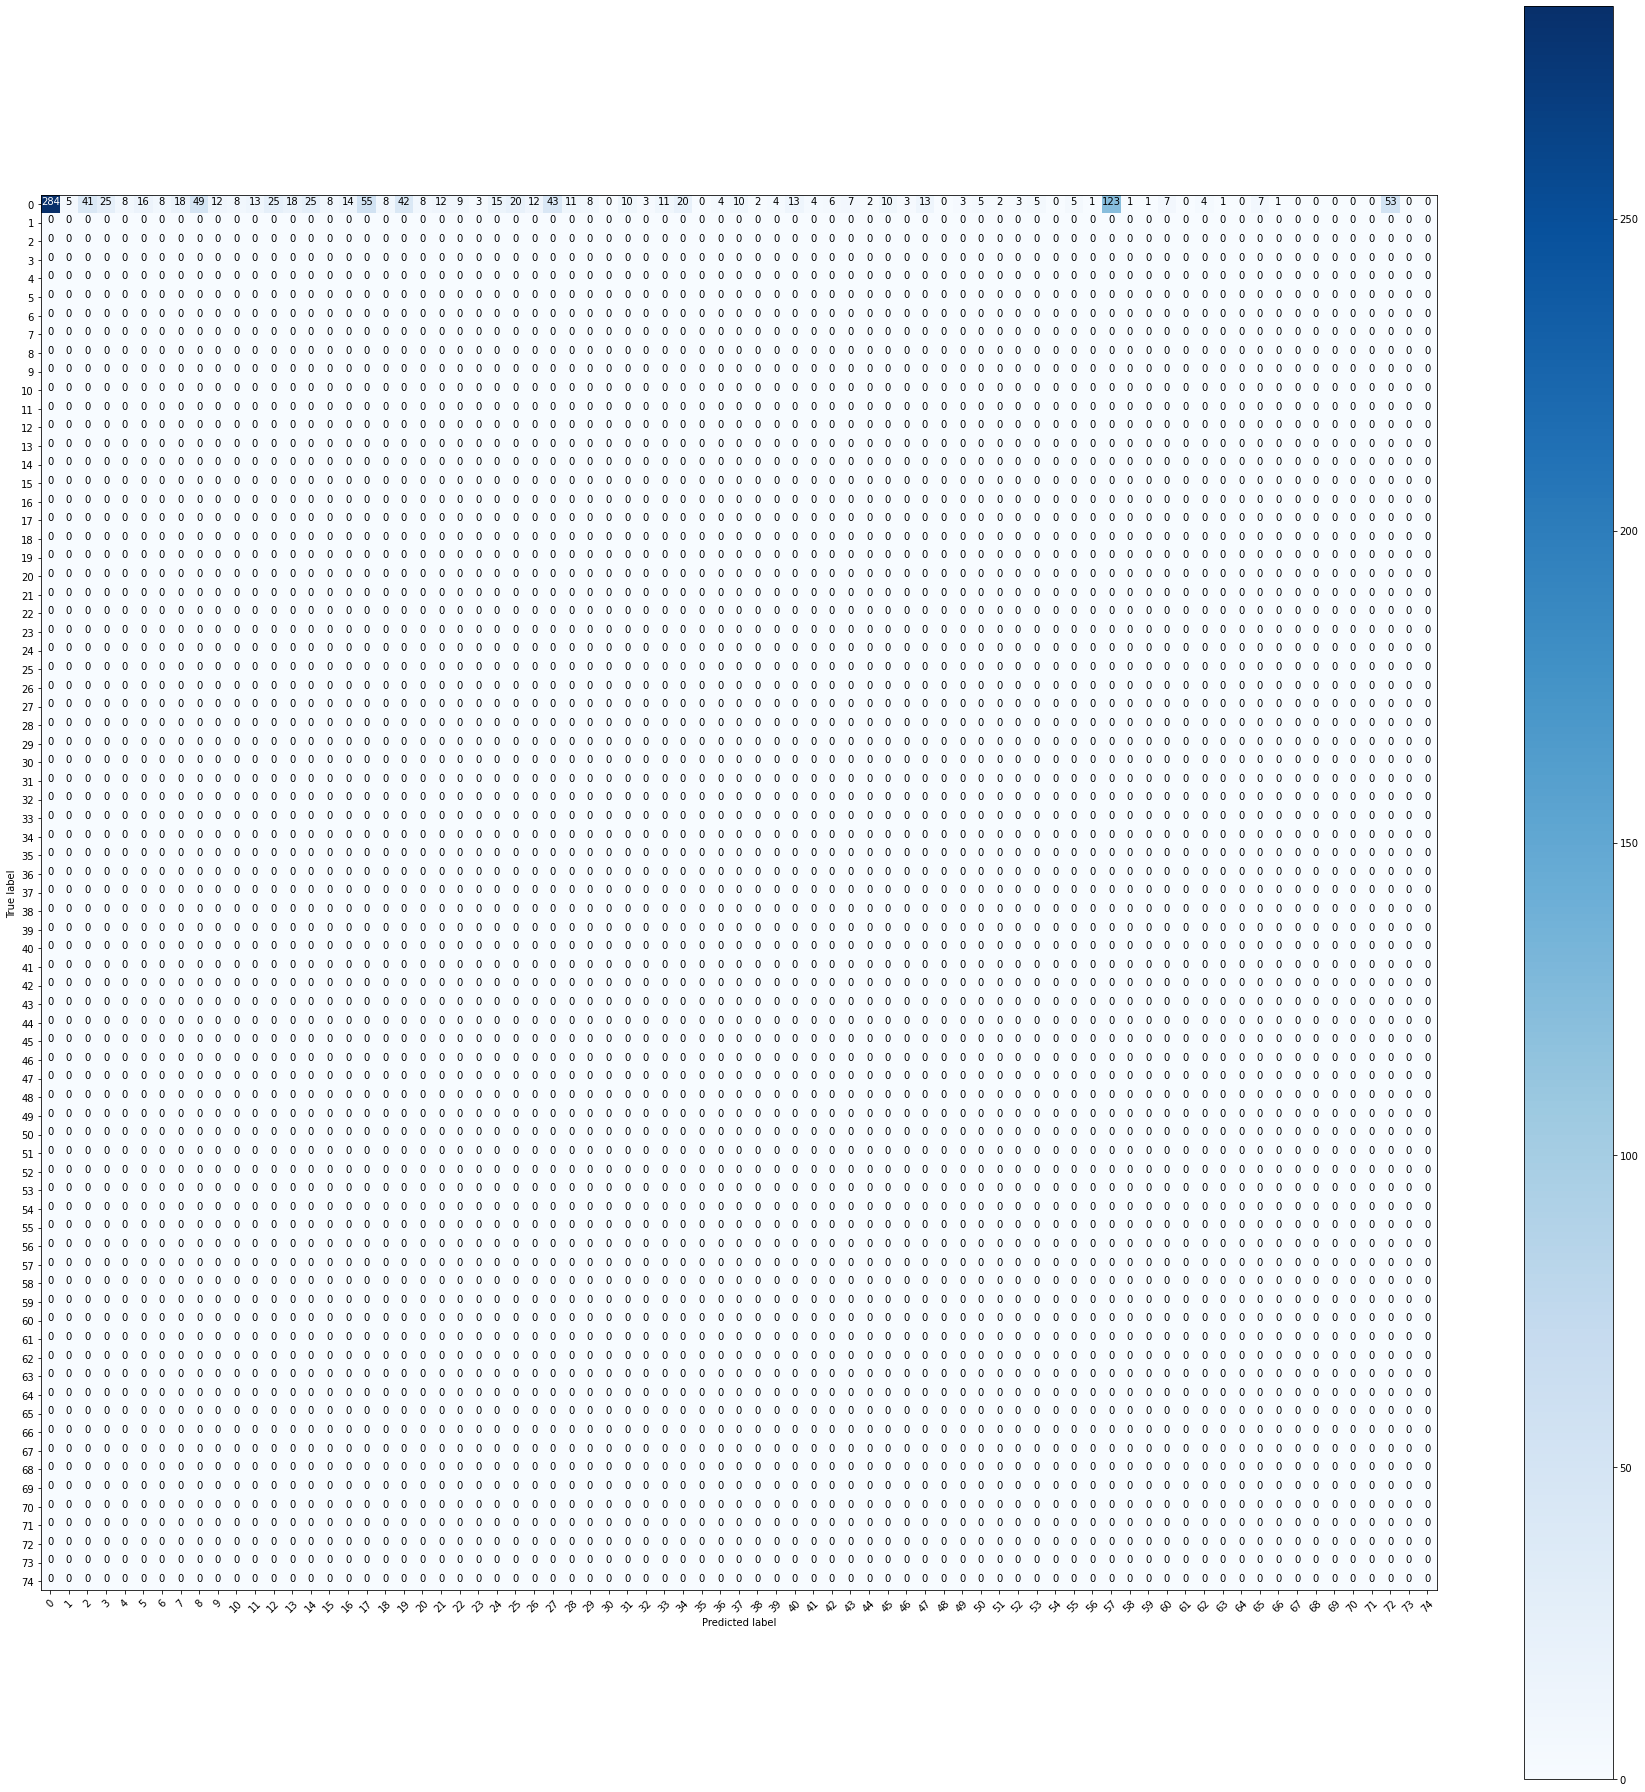

In [82]:
cnf_matrix = confusion_matrix(pd.DataFrame(y_test).values.argmax(axis=1), y_pred,#nb2 = GridSearchCV(GaussianNB(), cv=skf, param_grid=params)
                              labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                      31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,
                                      62,63,64,65,66,67,68,69,70,71,72,73,74])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                      31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,
                                      62,63,64,65,66,67,68,69,70,71,72,73,74],
                      title='Confusion matrix, without normalization')

In [83]:

for i in range(len(y_test)):
    print('Expected:', y_test[i], 'Predicted', y_pred[i])


Expected: 2 Predicted 20
Expected: 8 Predicted 57
Expected: 8 Predicted 13
Expected: 28 Predicted 13
Expected: 6 Predicted 57
Expected: 29 Predicted 0
Expected: 0 Predicted 37
Expected: 0 Predicted 72
Expected: 0 Predicted 0
Expected: 0 Predicted 17
Expected: 19 Predicted 0
Expected: 0 Predicted 2
Expected: 0 Predicted 0
Expected: 0 Predicted 15
Expected: 10 Predicted 18
Expected: 0 Predicted 27
Expected: 9 Predicted 57
Expected: 4 Predicted 0
Expected: 9 Predicted 57
Expected: 18 Predicted 31
Expected: 0 Predicted 17
Expected: 18 Predicted 18
Expected: 0 Predicted 25
Expected: 0 Predicted 17
Expected: 0 Predicted 0
Expected: 0 Predicted 19
Expected: 0 Predicted 17
Expected: 0 Predicted 23
Expected: 8 Predicted 5
Expected: 15 Predicted 0
Expected: 8 Predicted 8
Expected: 0 Predicted 29
Expected: 0 Predicted 22
Expected: 0 Predicted 72
Expected: 0 Predicted 42
Expected: 9 Predicted 0
Expected: 8 Predicted 8
Expected: 25 Predicted 25
Expected: 42 Predicted 33
Expected: 0 Predicted 59
Exp

In [ ]:
zeroes=[x for x in processed['Description'] if len(x)==0]

In [ ]:
len(zeroes)

337

In [ ]:
processed

0       [user, employe, manag, name, check, user, name...
1       [hello, team, outlook, calendar, somebodi, ple...
2                                 [hi, cannot, log, best]
3                             [unabl, access, tool, page]
4                                                 [error]
                              ...                        
8495          [good, afternoon, sent, mail, pleas, advis]
8496                                    [telephoni, issu]
8497                                    [password, reset]
8498    [unabl, access, machin, finish, drawer, adjust...
8499                                                   []
Name: Description, Length: 8499, dtype: object

In [ ]:
processed.isna().sum()

Description         0
Assignment group    0
dtype: int64

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow.python'

ANOTHER TRY, LEARNING FROM TENSORFLOW HUB

In [ ]:
import tensorflow

In [ ]:
!pip uninstall tensorflow==2.0.0

In [ ]:
!pip install tensorflow==1.15.0
#!pip install tensorflow-gpu==1.15.0


In [ ]:
!pip install bert-tensorflow

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In [ ]:
#from bert import *
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
#import tensorflow.compat.v1.train.Optimizer as opt

AttributeError: module 'tensorflow_core._api.v2.train' has no attribute 'Optimizer'

In [ ]:
#input1=pd.read_excel('input_data.xlsx')

In [ ]:
!pip install scikit-learn

In [ ]:
processed

,Description,Assignment group
0,verifi user detail employe manag name check us...,0
1,hmjdrvpb komuaywn hello team meet skype meet e...,0
2,eylqgodm ybqkwiam hi cannot log vpn best,0
3,unabl access hr tool page,0
4,skype error,0
...,...,...
8495,avglmrt vhqmtiua good afternoon receiv email s...,29
8496,telephoni softwar issu,0
8497,vip window password reset tifpdchb pedxruyf,0
8498,unabl access machin util finish drawer adjust ...,62


In [ ]:
len(inputdata)

8500

In [ ]:
inputdata.dtypes

Description         object
Assignment group     int32
dtype: object

In [ ]:
train = inputdata.iloc[2000:]
test=inputdata.iloc[:2000]

In [ ]:
train=train.drop(2004) # drop null
train

,Description,Assignment group
2000,monitor tool compani com job job fail job schedul,8
2001,zuxcfonv nyhpkrb gso account vvlixthi expir co...,2
2002,account lock,31
2003,weqocbnu eoixcpvi hi pleas reset password sid ...,0
2005,password reset use password manag tool,0
...,...,...
8495,avglmrt vhqmtiua good afternoon receiv email s...,29
8496,telephoni softwar issu,0
8497,vip window password reset tifpdchb pedxruyf,0
8498,unabl access machin util finish drawer adjust ...,62


In [ ]:
label_list = processed['Assignment group'].unique()
label_list

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 32, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73], dtype=int32)

In [ ]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['Description'], 
                                                                   text_b = None, 
                                                                   label = x['Assignment group']), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['Description'], 
                                                                   text_b = None, 
                                                                   label = x['Assignment group']), axis = 1)

In [ ]:
train_InputExamples

2000    <bert.run_classifier.InputExample object at 0x...
2001    <bert.run_classifier.InputExample object at 0x...
2002    <bert.run_classifier.InputExample object at 0x...
2003    <bert.run_classifier.InputExample object at 0x...
2005    <bert.run_classifier.InputExample object at 0x...
                              ...                        
8495    <bert.run_classifier.InputExample object at 0x...
8496    <bert.run_classifier.InputExample object at 0x...
8497    <bert.run_classifier.InputExample object at 0x...
8498    <bert.run_classifier.InputExample object at 0x...
8499    <bert.run_classifier.InputExample object at 0x...
Length: 6499, dtype: object

In [ ]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [ ]:
def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
tokenizer.tokenize(train.iloc[2765]['Description'])

['una', '##bl', 'connect', 'outlook']

In [ ]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 6499


INFO:tensorflow:Writing example 0 of 6499


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] monitor tool com ##pani com job job fail job sc ##hed ##ul [SEP]


INFO:tensorflow:tokens: [CLS] monitor tool com ##pani com job job fail job sc ##hed ##ul [SEP]


INFO:tensorflow:input_ids: 101 8080 6994 4012 26569 4012 3105 3105 8246 3105 8040 9072 5313 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8080 6994 4012 26569 4012 3105 3105 8246 3105 8040 9072 5313 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 8 (id = 7)


INFO:tensorflow:label: 8 (id = 7)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] zu ##x ##c ##fo ##n ##v ny ##hp ##kr ##b gs ##o account v ##v ##li ##xt ##hi ex ##pi ##r could extend account date oct ja ##cy ##h ##ki liu ##hy ##t sponsor ja ##cy ##h ##ki liu ##hy ##t [SEP]


INFO:tensorflow:tokens: [CLS] zu ##x ##c ##fo ##n ##v ny ##hp ##kr ##b gs ##o account v ##v ##li ##xt ##hi ex ##pi ##r could extend account date oct ja ##cy ##h ##ki liu ##hy ##t sponsor ja ##cy ##h ##ki liu ##hy ##t [SEP]


INFO:tensorflow:input_ids: 101 16950 2595 2278 14876 2078 2615 6396 22269 21638 2497 28177 2080 4070 1058 2615 3669 18413 4048 4654 8197 2099 2071 7949 4070 3058 13323 14855 5666 2232 3211 8607 10536 2102 10460 14855 5666 2232 3211 8607 10536 2102 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16950 2595 2278 14876 2078 2615 6396 22269 21638 2497 28177 2080 4070 1058 2615 3669 18413 4048 4654 8197 2099 2071 7949 4070 3058 13323 14855 5666 2232 3211 8607 10536 2102 10460 14855 5666 2232 3211 8607 10536 2102 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 19)


INFO:tensorflow:label: 2 (id = 19)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] account lock [SEP]


INFO:tensorflow:tokens: [CLS] account lock [SEP]


INFO:tensorflow:input_ids: 101 4070 5843 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4070 5843 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 31 (id = 31)


INFO:tensorflow:label: 31 (id = 31)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] we ##q ##oc ##bn ##u e ##oi ##x ##cp ##vi hi pleas reset password sid enter error time user name cao ##ry ##hu ##q south ser ##vic com ##pani com mail ##to south ser ##vic com ##pani com best [SEP]


INFO:tensorflow:tokens: [CLS] we ##q ##oc ##bn ##u e ##oi ##x ##cp ##vi hi pleas reset password sid enter error time user name cao ##ry ##hu ##q south ser ##vic com ##pani com mail ##to south ser ##vic com ##pani com best [SEP]


INFO:tensorflow:input_ids: 101 2057 4160 10085 24700 2226 1041 10448 2595 21906 5737 7632 22512 25141 20786 15765 4607 7561 2051 5310 2171 12966 2854 6979 4160 2148 14262 7903 4012 26569 4012 5653 3406 2148 14262 7903 4012 26569 4012 2190 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2057 4160 10085 24700 2226 1041 10448 2595 21906 5737 7632 22512 25141 20786 15765 4607 7561 2051 5310 2171 12966 2854 6979 4160 2148 14262 7903 4012 26569 4012 5653 3406 2148 14262 7903 4012 26569 4012 2190 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] password reset use password mana ##g tool [SEP]


INFO:tensorflow:tokens: [CLS] password reset use password mana ##g tool [SEP]


INFO:tensorflow:input_ids: 101 20786 25141 2224 20786 24951 2290 6994 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 20786 25141 2224 20786 24951 2290 6994 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ve ##ri ##fi user detail employ ##e mana ##g name check user name ad reset password ad ##vis user log ##in check caller confirm ab ##l log ##in iss ##u res ##ol ##v [SEP]


INFO:tensorflow:tokens: [CLS] ve ##ri ##fi user detail employ ##e mana ##g name check user name ad reset password ad ##vis user log ##in check caller confirm ab ##l log ##in iss ##u res ##ol ##v [SEP]


INFO:tensorflow:input_ids: 101 2310 3089 8873 5310 6987 12666 2063 24951 2290 2171 4638 5310 2171 4748 25141 20786 4748 11365 5310 8833 2378 4638 20587 12210 11113 2140 8833 2378 26354 2226 24501 4747 2615 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2310 3089 8873 5310 6987 12666 2063 24951 2290 2171 4638 5310 2171 4748 25141 20786 4748 11365 5310 8833 2378 4638 20587 12210 11113 2140 8833 2378 26354 2226 24501 4747 2615 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hm ##j ##dr ##v ##p ##b ko ##mu ##ay ##wn hello team meet sky ##pe meet etc appear outlook calendar some ##bo ##di pleas ad ##vis correct kind [SEP]


INFO:tensorflow:tokens: [CLS] hm ##j ##dr ##v ##p ##b ko ##mu ##ay ##wn hello team meet sky ##pe meet etc appear outlook calendar some ##bo ##di pleas ad ##vis correct kind [SEP]


INFO:tensorflow:input_ids: 101 20287 3501 13626 2615 2361 2497 12849 12274 4710 7962 7592 2136 3113 3712 5051 3113 4385 3711 17680 8094 2070 5092 4305 22512 4748 11365 6149 2785 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 20287 3501 13626 2615 2361 2497 12849 12274 4710 7962 7592 2136 3113 3712 5051 3113 4385 3711 17680 8094 2070 5092 4305 22512 4748 11365 6149 2785 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] e ##yl ##q ##go ##dm y ##b ##q ##k ##wi ##am hi cannot log vp ##n best [SEP]


INFO:tensorflow:tokens: [CLS] e ##yl ##q ##go ##dm y ##b ##q ##k ##wi ##am hi cannot log vp ##n best [SEP]


INFO:tensorflow:input_ids: 101 1041 8516 4160 3995 22117 1061 2497 4160 2243 9148 3286 7632 3685 8833 21210 2078 2190 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1041 8516 4160 3995 22117 1061 2497 4160 2243 9148 3286 7632 3685 8833 21210 2078 2190 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] una ##bl access hr tool page [SEP]


INFO:tensorflow:tokens: [CLS] una ##bl access hr tool page [SEP]


INFO:tensorflow:input_ids: 101 14477 16558 3229 17850 6994 3931 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 14477 16558 3229 17850 6994 3931 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sky ##pe error [SEP]


INFO:tensorflow:tokens: [CLS] sky ##pe error [SEP]


INFO:tensorflow:input_ids: 101 3712 5051 7561 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3712 5051 7561 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


In [ ]:
train_features[8]

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 64#32
LEARNING_RATE = 2e-4
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [ ]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [ ]:
OUTPUT_DIR=r'C:\Users\analy\Documents\AI_ML_Course\Capstone_Project'
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\analy\\Documents\\AI_ML_Course\\Capstone_Project', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b74aab9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\analy\\Documents\\AI_ML_Course\\Capstone_Project', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b74aab9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\analy\\Documents\\AI_ML_Course\\Capstone_Project', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc1bac17898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\analy\\Documents\\AI_ML_Course\\Capstone_Project', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc1bac17898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [ ]:
from datetime import datetime

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\analy\Documents\AI_ML_Course\Capstone_Project/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\analy\Documents\AI_ML_Course\Capstone_Project/model.ckpt.


INFO:tensorflow:loss = 4.2762747, step = 1


INFO:tensorflow:loss = 4.2762747, step = 1


INFO:tensorflow:global_step/sec: 0.0319825


INFO:tensorflow:global_step/sec: 0.0319825


INFO:tensorflow:loss = 3.3718517, step = 101 (3126.709 sec)


INFO:tensorflow:loss = 3.3718517, step = 101 (3126.709 sec)


INFO:tensorflow:global_step/sec: 0.0322243


INFO:tensorflow:global_step/sec: 0.0322243


INFO:tensorflow:loss = 3.8237433, step = 201 (3103.249 sec)


INFO:tensorflow:loss = 3.8237433, step = 201 (3103.249 sec)


Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\analy\Documents\AI_ML_Course\Capstone_Project/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\analy\Documents\AI_ML_Course\Capstone_Project/model.ckpt.


INFO:tensorflow:loss = 4.2762747, step = 1


INFO:tensorflow:loss = 4.2762747, step = 1


INFO:tensorflow:global_step/sec: 0.0319825


INFO:tensorflow:global_step/sec: 0.0319825


INFO:tensorflow:loss = 3.3718517, step = 101 (3126.709 sec)


INFO:tensorflow:loss = 3.3718517, step = 101 (3126.709 sec)


INFO:tensorflow:global_step/sec: 0.0322243


INFO:tensorflow:global_step/sec: 0.0322243


INFO:tensorflow:loss = 3.8237433, step = 201 (3103.249 sec)


INFO:tensorflow:loss = 3.8237433, step = 201 (3103.249 sec)


In [ ]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)


NameError: ignored

In [ ]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

In [ ]:
def getPrediction(in_sentences):
  labels = label_list
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]